### Feature selecture using target permutation

The notebook uses a procedure described in [this article]( https://academic.oup.com/bioinformatics/article/26/10/1340/193348).

Feature selection process using target permutation tests actual importance significance against the distribution of feature importances when fitted to noise (shuffled target).

The notebook implements the following steps  :
 - Create the null importances distributions : these are created fitting the model over several runs on a shuffled version of the target. This shows how the model can make sense of a feature irrespective of the target.
 - Fit the model on the original target and gather the feature importances. This gives us a benchmark whose significance can be tested against the Null Importances Distribution
 - for each feature test the actual importance:
    - Compute the probabability of the actual importance wrt the null distribution. I will use a very simple estimation using occurences while the article proposes to fit known distribution to the gathered data. In fact here I'll compute 1 - the proba so that things are in the right order.
    - Simply compare the actual importance to the mean and max of the null importances. This will give sort of a feature importance that allows to see major features in the dataset. Indeed the previous method may give us lots of ones.

For processing time reasons, the notebook will only cover application_train.csv but you can extend it as you wish.


### Import a few packages

In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
from lightgbm import LGBMClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter('ignore', UserWarning)

import gc
gc.enable()

/Users/ribhunirek/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


### Read application_train

Read data and take care of categorical features

In [3]:
data = pd.read_csv('application_train.csv')

categorical_feats = [
    f for f in data.columns if data[f].dtype == 'object'
]

categorical_feats
for f_ in categorical_feats:
    data[f_], _ = pd.factorize(data[f_])
    # Set feature type as categorical
    data[f_] = data[f_].astype('category')

In [4]:
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,0,0,0,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,1,0,1,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,0,1,0,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,1,0,0,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,0,0,0,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Create a scoring function

Scoring function uses LightGBM in RandomForest mode fitted on the full dataset 

In [5]:
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    train_features = [f for f in data if f not in ['TARGET', 'SK_ID_CURR']]
    # Go over fold and keep track of CV score (train and valid) and feature importances
    
    # Shuffle target if required
    y = data['TARGET'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['TARGET'].copy().sample(frac=1.0)
    
    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 4
    }
    
    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200, categorical_feature=categorical_feats)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    
    return imp_df

### Build the benchmark for feature importance

![](http://)The original paper does not talk about this but I think it makes sense to have a distribution of actual importances as well

In [6]:
# Seed the unexpected randomness of this world
np.random.seed(123)
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=data, shuffle=False)

In [7]:
actual_imp_df.head()

,feature,importance_gain,importance_split,trn_score
0,NAME_CONTRACT_TYPE,4819.676787,131,0.757462
1,CODE_GENDER,24090.765133,512,0.757462
2,FLAG_OWN_CAR,2666.568874,81,0.757462
3,FLAG_OWN_REALTY,696.747799,32,0.757462
4,CNT_CHILDREN,930.877024,40,0.757462


### Build Null Importances distribution

In [8]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=data, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with   80 of   80 (Spent  25.8 min)

In [9]:
null_imp_df.head()

,feature,importance_gain,importance_split,trn_score,run
0,NAME_CONTRACT_TYPE,178.969080,24,0.714683,1
1,CODE_GENDER,387.732955,74,0.714683,1
2,FLAG_OWN_CAR,237.031107,37,0.714683,1
3,FLAG_OWN_REALTY,430.885483,58,0.714683,1
4,CNT_CHILDREN,577.820721,60,0.714683,1


### Display distribution examples

A few plots are better than any words

In [10]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())
        

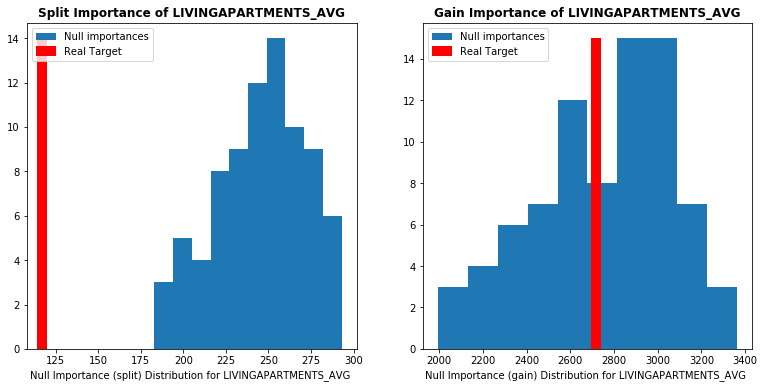

In [11]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='LIVINGAPARTMENTS_AVG')

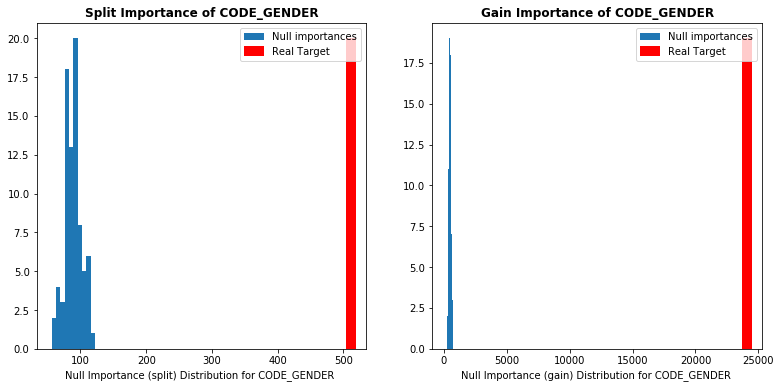

In [12]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='CODE_GENDER')

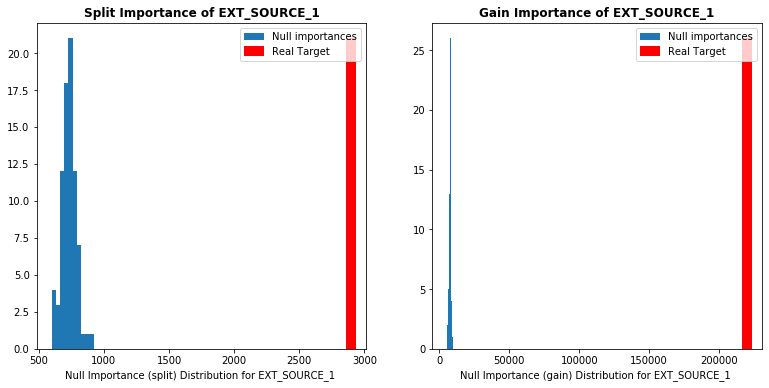

In [13]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='EXT_SOURCE_1')

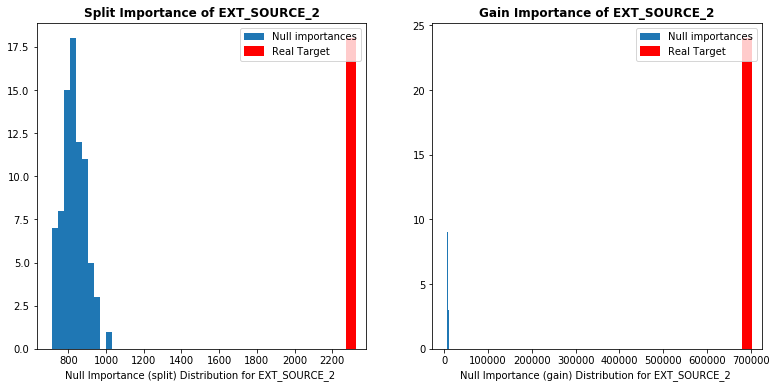

In [14]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='EXT_SOURCE_2')

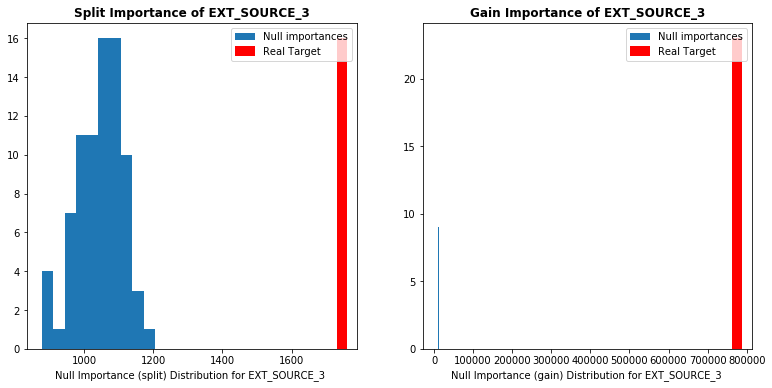

In [15]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='EXT_SOURCE_3')

From the above plot I believe the power of the exposed feature selection method is demonstrated. In particular it is well known that :
 - Any feature sufficient variance can be used and made sense of by tree models. You can always find splits that help scoring better
 - Correlated features have decaying importances once one of them is used by the model. The chosen feature will have strong importance and its correlated suite will have decaying importances
 
 The current method allows to :
  - Drop high variance features if they are not really related to the target
  - Remove the decaying factor on correlated features, showing their real importance (or unbiased importance)


### Score features

There are several ways to score features : 
 - Compute the number of samples in the actual importances that are away from the null importances recorded distribution.
 - Compute ratios like Actual / Null Max, Actual  / Null Mean,  Actual Mean / Null Max
 
In a first step I will use the log actual feature importance divided by the 75 percentile of null distribution.

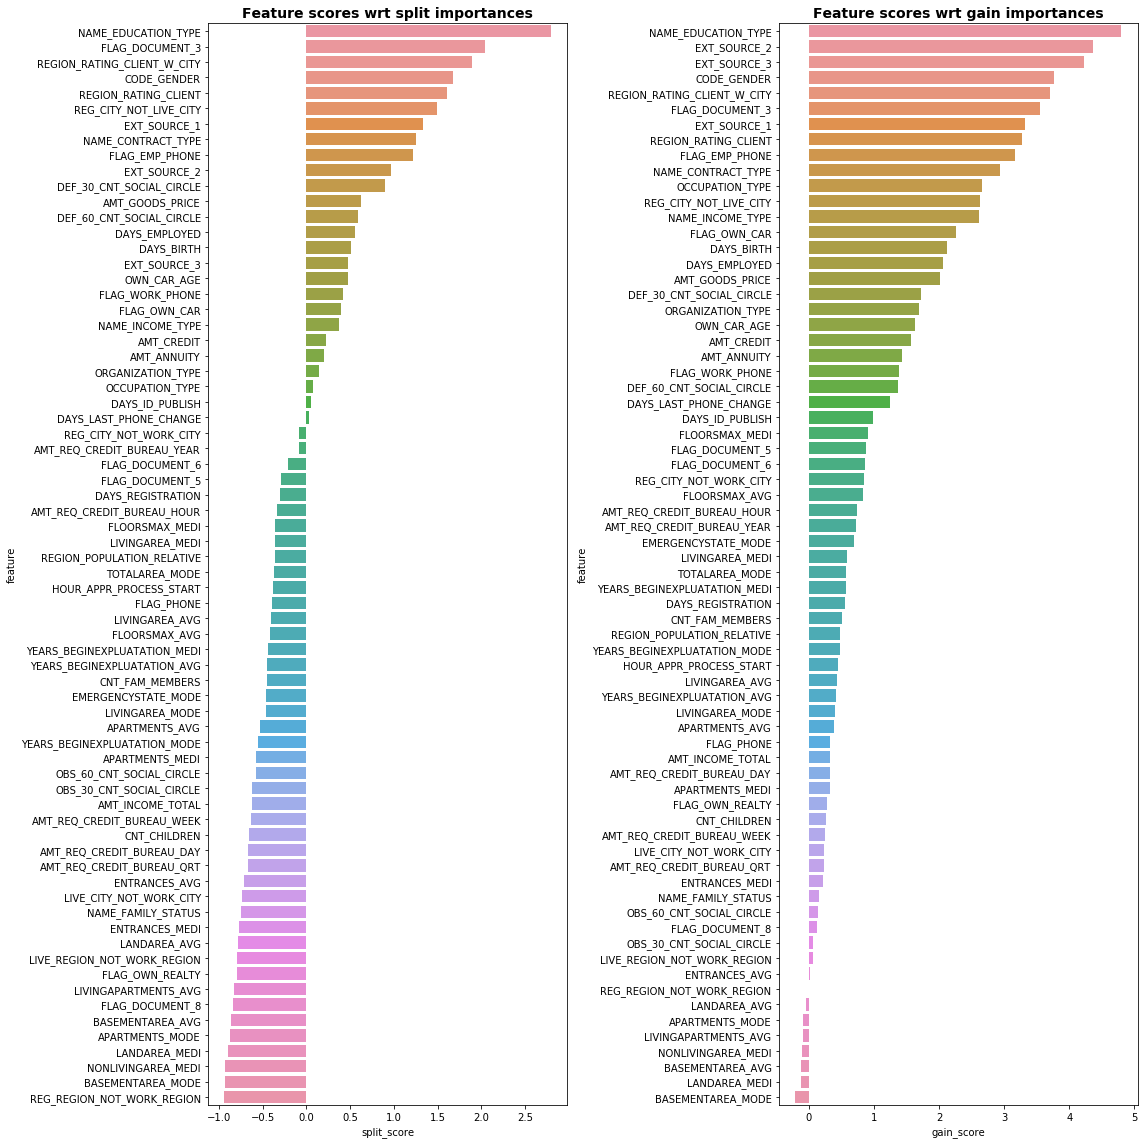

In [16]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

### Save data

In [17]:
null_imp_df.to_csv('null_importances_distribution_rf.csv')
actual_imp_df.to_csv('actual_importances_ditribution_rf.csv')

### Check the impact of removing uncorrelated features

Here I'll use a different metric to asses correlation to the target

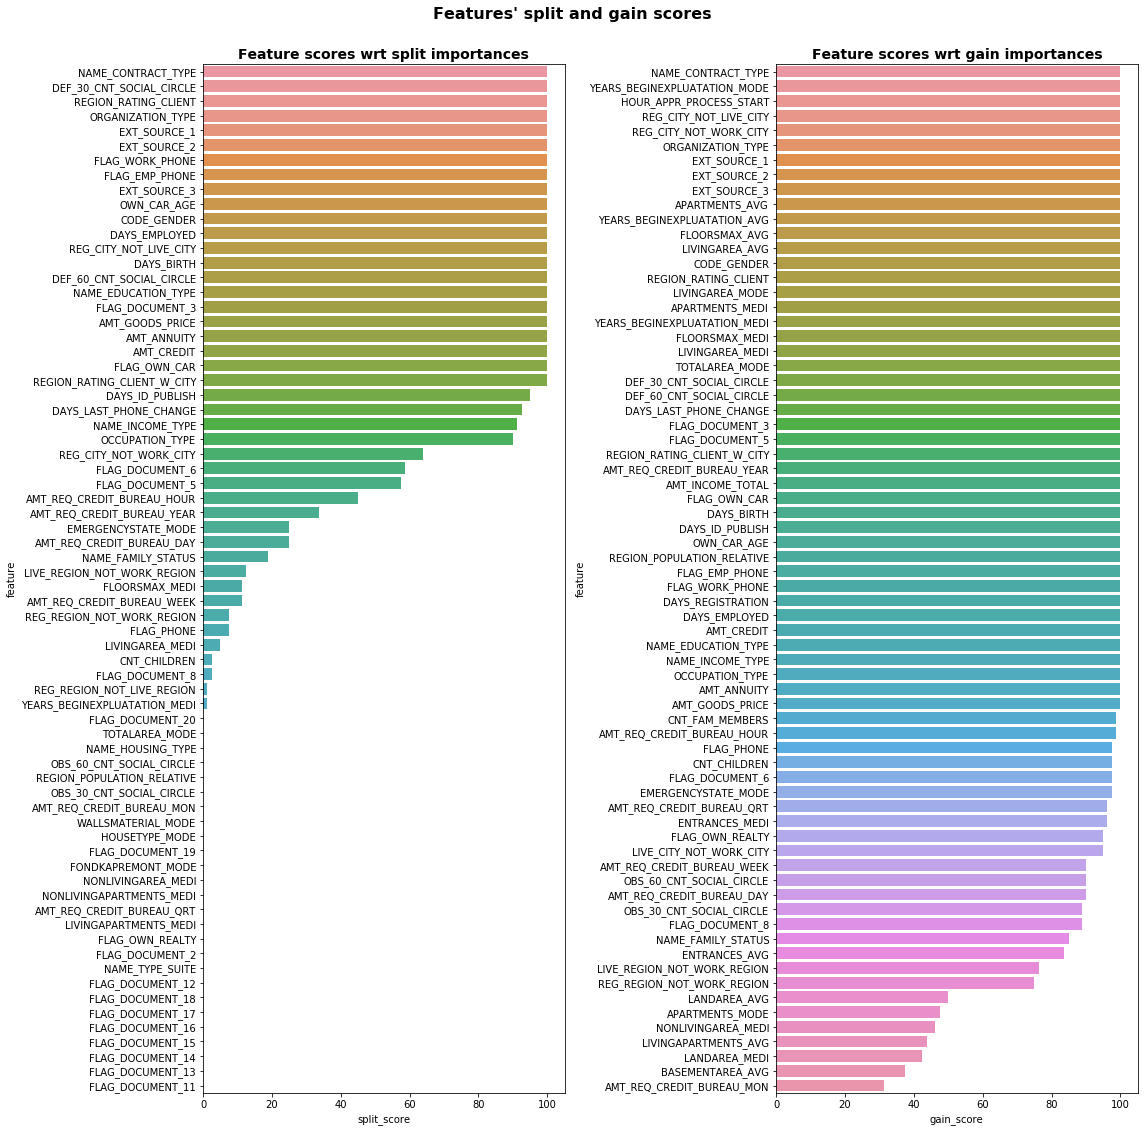

In [18]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

### Score feature removal for different thresholds

In [19]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    # Fit LightGBM 
    dtrain = lgb.Dataset(df[train_features], target, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'learning_rate': .1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'num_leaves': 31,
        'max_depth': -1,
        'seed': 13,
        'n_jobs': 4,
        'min_split_gain': .00001,
        'reg_alpha': .00001,
        'reg_lambda': .00001,
        'metric': 'auc'
    }
    
    # Fit the model
    hist = lgb.cv(
        params=lgb_params, 
        train_set=dtrain, 
        num_boost_round=2000,
        categorical_feature=cat_feats,
        nfold=5,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=50,
        verbose_eval=0,
        seed=17
    )
    # Return the last mean / std values 
    return hist['auc-mean'][-1], hist['auc-stdv'][-1]

# features = [f for f in data.columns if f not in ['SK_ID_CURR', 'TARGET']]
# score_feature_selection(df=data[features], train_features=features, target=data['TARGET'])

for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in categorical_feats)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=data, train_features=split_feats, cat_feats=split_cat_feats, target=data['TARGET'])
    print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
    gain_results = score_feature_selection(df=data, train_features=gain_feats, cat_feats=gain_cat_feats, target=data['TARGET'])
    print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))


Results for threshold   0
	 SPLIT : 0.756798 +/- 0.004663
	 GAIN  : 0.756798 +/- 0.004663
Results for threshold  10
	 SPLIT : 0.756387 +/- 0.003930
	 GAIN  : 0.756514 +/- 0.003564
Results for threshold  20
	 SPLIT : 0.755862 +/- 0.004090
	 GAIN  : 0.756076 +/- 0.003649
Results for threshold  30
	 SPLIT : 0.756301 +/- 0.003498
	 GAIN  : 0.756353 +/- 0.004088
Results for threshold  40
	 SPLIT : 0.755691 +/- 0.003761
	 GAIN  : 0.756174 +/- 0.003668
Results for threshold  50
	 SPLIT : 0.754963 +/- 0.003898
	 GAIN  : 0.756038 +/- 0.004126
Results for threshold  60
	 SPLIT : 0.755340 +/- 0.003905
	 GAIN  : 0.756529 +/- 0.003956
Results for threshold  70
	 SPLIT : 0.755184 +/- 0.003868
	 GAIN  : 0.756529 +/- 0.003956
Results for threshold  80
	 SPLIT : 0.755184 +/- 0.003868
	 GAIN  : 0.756241 +/- 0.003668
Results for threshold  90
	 SPLIT : 0.755184 +/- 0.003868
	 GAIN  : 0.756093 +/- 0.003995
Results for threshold  95
	 SPLIT : 0.755172 +/- 0.004070
	 GAIN  : 0.756019 +/- 0.003969
Results fo